# SAM2 Video Segmentation Experiment

In [1]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from sam2.build_sam import build_sam2_video_predictor
import concurrent.futures
from tqdm import tqdm
from PIL import Image

In [2]:


CHECKPOINT = "./sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT, device=DEVICE)


In [3]:
# Data Preparation: Convert png to JEPG
data_dir = Path('./snemi')
raw_image_pngs = data_dir / "image_pngs"
seg_pngs = data_dir / "seg_pngs"
raw_image_jpgs = data_dir / "image_jpgs"
seg_jpgs = data_dir / "seg_jpgs"
test_image_pngs = data_dir / "image_test_pngs"
test_image_pred_pngs = data_dir / "image_pred_test_pngs"
test_image_jpgs = data_dir / "image_test_jpgs"
test_image_pred_jpgs = data_dir / "image_pred_test_jpgs"
os.makedirs(test_image_jpgs, exist_ok = True)
os.makedirs(test_image_pred_jpgs, exist_ok = True)
os.makedirs(raw_image_jpgs, exist_ok = True)
os.makedirs(seg_jpgs, exist_ok = True)

In [4]:
image_png_files =sorted( [raw_image_pngs / filename for filename in os.listdir(raw_image_pngs)])
seg_png_files = sorted([seg_pngs / filename for filename in os.listdir(seg_pngs)])
test_image_png_files = sorted( [test_image_pngs / filename for filename in os.listdir(test_image_pngs)])
test_image_pred_png_files = sorted( [test_image_pred_pngs / filename for filename in os.listdir(test_image_pred_pngs)])
def convertpng2jpg(file_path, target_dir):
    img = Image.open(file_path)
    rbg_img = img.convert('RGB')
    file_name = file_path.stem 
    digits = int(file_name[-4:])
    target_path = target_dir / (f'{digits:05d}.jpeg')
    rbg_img.save(target_path, format='JPEG')
    return target_path
image_jpg_files = [convertpng2jpg(file_path, raw_image_jpgs) for file_path in image_png_files]
seg_jpg_files = [convertpng2jpg(file_path, seg_jpgs) for file_path in seg_png_files]
test_image_jpg_files = [convertpng2jpg(file_path, test_image_jpgs) for file_path in test_image_png_files]
test_image_pred_jpg_files = [convertpng2jpg(file_path, test_image_pred_jpgs ) for file_path in test_image_pred_png_files]

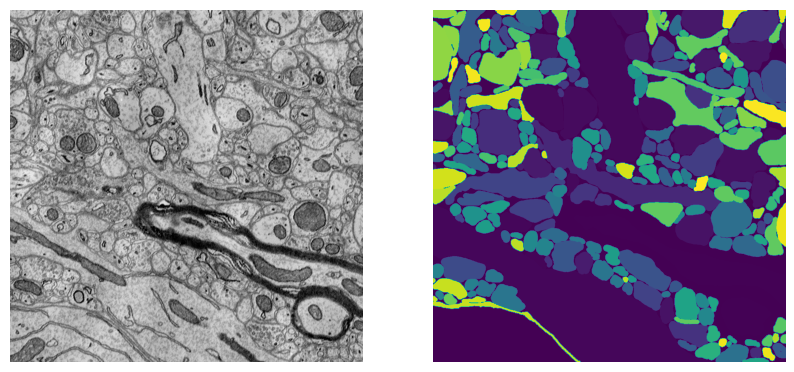

In [5]:
# - Verify the Converted Image
image0000 = Image.open(image_jpg_files[0])
seg0000 = Image.open(seg_png_files[0])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image0000)
axs[0].axis('off')

axs[1].imshow(seg0000)
axs[1].axis('off')

plt.show()


In [6]:
# inference_state = sam2_model.init_state(str(raw_image_jpgs))


In [7]:
# # - visualize image and mask
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [8]:
# frame_names = image_jpg_files 
# ann_frame_idx = 0  # the frame index we interact with
# ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# # Let's add a positive click at (x, y) = (210, 350) to get started
# points = np.array([[210, 350]], dtype=np.float32)
# # for labels, `1` means positive click and `0` means negative click
# labels = np.array([1], np.int32)
# _, out_obj_ids, out_mask_logits = sam2_model.add_new_points_or_box(
#     inference_state=inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id,
#     points=points,
#     labels=labels,
# )

# # show the results on the current (interacted) frame
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx}")
# plt.imshow(Image.open(frame_names[ann_frame_idx]))
# show_points(points, labels, plt.gca())
# show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [9]:
# # run propagation throughout the video and collect the results in a dict
# video_segments = {}  # video_segments contains the per-frame segmentation results
# for out_frame_idx, out_obj_ids, out_mask_logits in sam2_model.propagate_in_video(inference_state):
#     video_segments[out_frame_idx] = {
#         out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
#         for i, out_obj_id in enumerate(out_obj_ids)
#     }
# # render the segmentation results every few frames
# vis_frame_stride = 30
# plt.close("all")
# for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
#     plt.figure(figsize=(6, 4))
#     plt.title(f"frame {out_frame_idx}")
#     plt.imshow(Image.open(frame_names[out_frame_idx]))
#     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [10]:
# # - Try add new mask to SAM2 
# sam2_model.reset_state(inference_state)
# frame_names = image_jpg_files 
# ann_frame_idx = 0  # the frame index we interact with
# ann_obj_id = 1 # give a unique id to each object we interact with (it can be any integers)

# # Let's add a positive click at (x, y) = (210, 350) to get started
# mask_image = Image.open(seg_jpg_files[ann_frame_idx])
# masks = np.array(mask_image)[..., 0]
# mask = np.zeros(masks.shape)
# mask[masks == ann_obj_id] = ann_obj_id
# # for labels, `1` means positive click and `0` means negative click
# # labels = np.array([1], np.int32)
# # _, out_obj_ids, out_mask_logits = sam2_model.add_new_points_or_box(
# #     inference_state=inference_state,
# #     frame_idx=ann_frame_idx,
# #     obj_id=ann_obj_id,
# #     points=points,
# #     labels=labels,
# # )

# # # show the results on the current (interacted) frame
# # plt.figure(figsize=(9, 6))
# # plt.title(f"frame {ann_frame_idx}")
# # plt.imshow(Image.open(frame_names[ann_frame_idx]))
# # show_points(points, labels, plt.gca())
# # show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [11]:
# plt.imshow(mask)

In [12]:
# _, out_obj_ids, out_mask_logits = sam2_model.add_new_mask(
#     inference_state = inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id,
#     mask = mask
# )
# # show the results on the current (interacted) frame
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx}")
# plt.imshow(Image.open(frame_names[ann_frame_idx]))
# show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [13]:
# # run propagation throughout the video and collect the results in a dict
# video_segments = {}  # video_segments contains the per-frame segmentation results
# for out_frame_idx, out_obj_ids, out_mask_logits in sam2_model.propagate_in_video(inference_state):
#     video_segments[out_frame_idx] = {
#         out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
#         for i, out_obj_id in enumerate(out_obj_ids)
#     }
# # render the segmentation results every few frames
# vis_frame_stride = 30
# plt.close("all")
# for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
#     plt.figure(figsize=(6, 4))
#     plt.title(f"frame {out_frame_idx}")
#     plt.imshow(Image.open(frame_names[out_frame_idx]))
#     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [14]:
# # - Try to segment multiple objects simultaneously
# sam2_model.reset_state(inference_state)
# prompts = {}
# ann_frame_idx = 0
# frame_names = image_jpg_files 

# mask_image = Image.open(seg_jpg_files[ann_frame_idx])
# masks = np.array(mask_image)[..., 0]
# ann_obj_ids = np.unique(masks)[:50]

# # - visualize mask
# temp_mask = mask = np.zeros(masks.shape)
# for obj_id in ann_obj_ids:
#     temp_mask[masks == obj_id] = obj_id
# plt.imshow(temp_mask)

# # - visualize objects
# for obj_id in ann_obj_ids:
#     mask = np.zeros(masks.shape)
#     mask[masks == obj_id] = obj_id
#     _, out_obj_ids, out_mask_logits = sam2_model.add_new_mask(
#     inference_state = inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=obj_id,
#     mask = mask)
    

In [15]:
# # run propagation throughout the video and collect the results in a dict
# video_segments = {}  # video_segments contains the per-frame segmentation results
# for out_frame_idx, out_obj_ids, out_mask_logits in sam2_model.propagate_in_video(inference_state):
#     video_segments[out_frame_idx] = {
#         out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
#         for i, out_obj_id in enumerate(out_obj_ids)
#     }


In [16]:
# # render the segmentation results every few frames
# vis_frame_stride = 10
# plt.close("all")
# for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
#     plt.figure(figsize=(6, 4))
#     plt.title(f"frame {out_frame_idx}")
#     plt.imshow(Image.open(frame_names[out_frame_idx]))
#     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [17]:
# - Experiment with my Test Image - batch processing
sam2_model_2 = build_sam2_video_predictor(CONFIG, CHECKPOINT, device=torch.device('cuda:1'))
inference_state = sam2_model.init_state(str(test_image_jpgs))
inference_state_2 = sam2_model_2.init_state(str(test_image_jpgs))

frame loading (JPEG): 100%|██████████| 100/100 [00:01<00:00, 52.38it/s]


In [18]:
# - Try to segment multiple objects simultaneously
def partial_segmentation_inference(sam2_model, inference_state, ann_frame_idx, frame_names, seg_frame_names, ann_obj_ids):
    sam2_model.reset_state(inference_state)

    mask_image = Image.open(seg_frame_names[ann_frame_idx])
    masks = np.array(mask_image)[..., 0]
    # - visualize mask
    temp_mask = mask = np.zeros(masks.shape)
    for obj_id in ann_obj_ids:
        temp_mask[masks == obj_id] = obj_id
    plt.imshow(temp_mask)

    # - visualize objects
    for obj_id in ann_obj_ids:
        mask = np.zeros(masks.shape)
        mask[masks == obj_id] = obj_id
        _, out_obj_ids, out_mask_logits = sam2_model.add_new_mask(
            inference_state = inference_state,
            frame_idx=ann_frame_idx,
            obj_id=obj_id,
            mask = mask)

    # run propagation throughout the video and collect the results in a dict
    video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in sam2_model.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
        
    return video_segments
    

Partial Inference Undergoing:   0%|          | 0/4 [00:00<?, ?it/s]/home/mitochondria/Desktop/yuxuan_exp/SAM2_finetuning/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:718.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/mitochondria/Desktop/yuxuan_exp/SAM2_finetuning/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/mitochondria/Desktop/yuxuan_exp/SAM2_finetuning/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:720.)
  out = F.scaled_dot_product

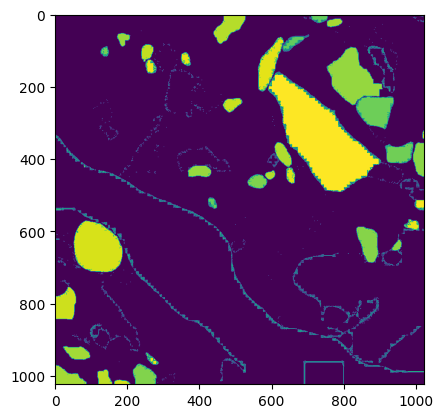

In [19]:
mask_image = Image.open(str(test_image_pred_jpg_files[0]))
masks = np.array(mask_image)[..., 0]
all_ann_obj_ids = np.unique(masks)[1:]

# Assuming all inputs now have the same length
model_input = [sam2_model, sam2_model_2, sam2_model, sam2_model_2]
inference_input = [inference_state, inference_state_2, inference_state, inference_state_2]
frame_idx = [0, 0, 0, 0]
frame_names_lst = [test_image_jpg_files, test_image_jpg_files, test_image_jpg_files, test_image_jpg_files]
seg_files = [test_image_pred_jpg_files, test_image_pred_jpg_files, test_image_pred_jpg_files, test_image_pred_jpg_files]
obj_id_lst = [all_ann_obj_ids[:50], all_ann_obj_ids[50:100], all_ann_obj_ids[100:150], all_ann_obj_ids[150:200]]

# Execute the function with ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    results = list(tqdm(
        executor.map(
            partial_segmentation_inference,
            model_input,
            inference_input,
            frame_idx,
            frame_names_lst,
            seg_files,
            obj_id_lst
        ), desc="Partial Inference Undergoing", total=4  # Set total to match the number of tasks
    ))


# with concurrent.futures.ThreadPoolExecutor(max_workers = 2) as executor:
#     results = list(tqdm(
#         executor.map(
#             partial_segmentation_inference,
#             model_input,
#             inference_input,
#             frame_idx,
#             frame_names_lst,
#             seg_files,
#             obj_id_lst
#         ), desc = f"Partial Inference Undergoing", total = 2
#     ))

# with concurrent.futures.ThreadPoolExecutor(max_workers = 2) as executor:
#     results_2 = list(tqdm(
#         executor.map(
#             partial_segmentation_inference,
#             model_input,
#             inference_input,
#             frame_idx,
#             frame_names_lst,
#             seg_files,
#             obj_id_2_lst
#         ), desc = f"Partial Inference Undergoing", total = 2
#     ))


In [20]:
video_segments = results[0]
for i in range(len(video_segments)):
    video_segments[i] = video_segments[i] | results[1][i] | results[2][i] | results[3][i] 

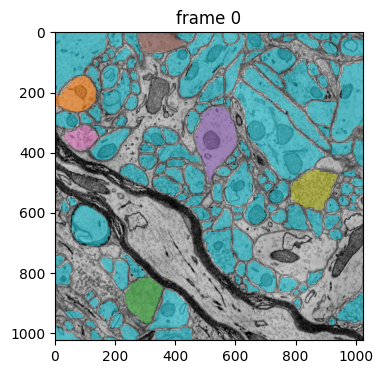

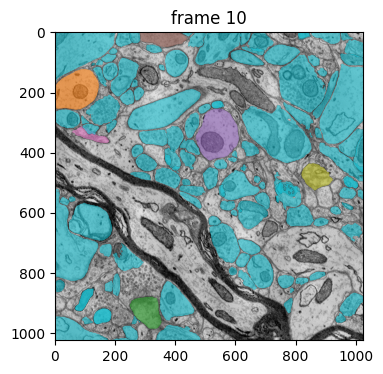

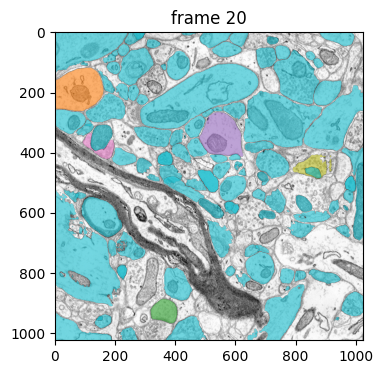

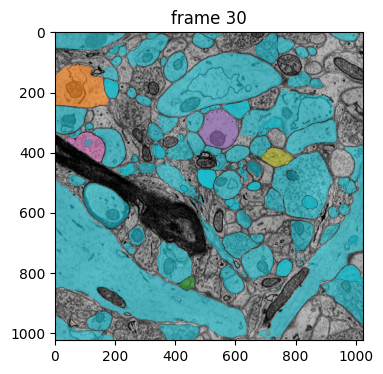

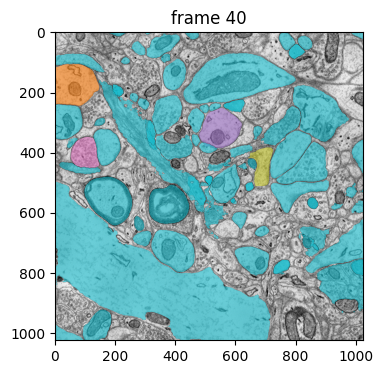

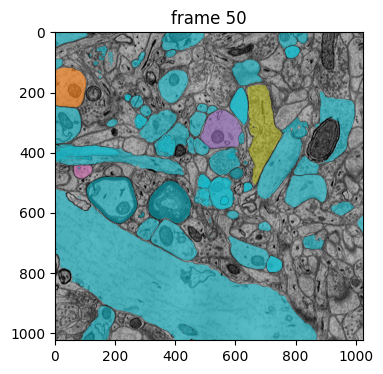

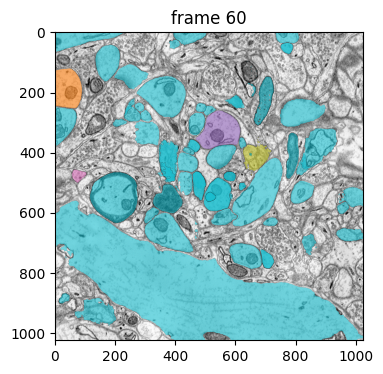

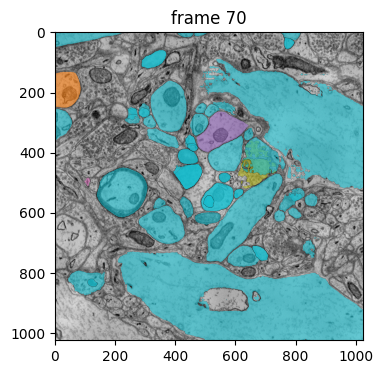

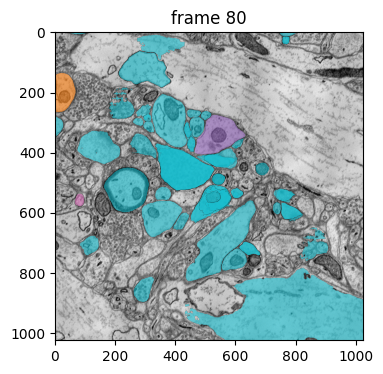

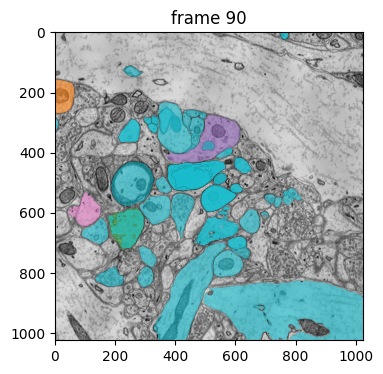

In [21]:
vis_frame_stride = 10
frame_names = test_image_jpg_files
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(frame_names[out_frame_idx]))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [22]:
flattened_data = {}
for outer_key, inner_dict in video_segments.items():
    for inner_key, mask in inner_dict.items():
        flattened_data[f'{outer_key}_{inner_key}'] = mask
np.savez_compressed("test_image_video_track_result.npz", **flattened_data)


In [24]:
video_segments[1]

{1: array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]]),
 2: array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]]),
 3: array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False

: 